# Initalization 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.test.gpu_device_name()

''

In [4]:
import pathlib
data_dir = pathlib.Path(r'\Users\elife\Documents\Jupyter-Notebook\MaskClassification\CMFD-LowetRes') 
count = len(list(data_dir.glob('*/*.jpg')))
print(count)

34526


# Setting up for Training

In [3]:
#Resize image to make better
batch_size = 32
img_height = 128
img_width = 128

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 34526 files belonging to 2 classes.
Using 27621 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 34526 files belonging to 2 classes.
Using 6905 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [8]:
#Last layer can't be relu must be sigmoid
#Sahil added batchnorm after every convulution layer 
#Also changed max to average poolng
#Dont need bias with batch norm
#USe mtcnn for facecam
model = Sequential([
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    
    layers.Conv2D(32, 3,padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, 3,padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.3), 
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])    

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [9]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 128, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1

In [11]:
# Sahil looks at code one epoch 100 accuracy
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print(history.history['val_accuracy'][epochs-1])

Epoch 1/3
864/864 [==============================] - 14352s 17s/step - loss: 0.0631 - accuracy: 0.9918 - val_loss: 0.0170 - val_accuracy: 0.9999
Epoch 2/3
864/864 [==============================] - 408s 472ms/step - loss: 0.0261 - accuracy: 0.9991 - val_loss: 0.0102 - val_accuracy: 0.9994
Epoch 3/3
864/864 [==============================] - 392s 454ms/step - loss: 0.0182 - accuracy: 0.9991 - val_loss: 0.0177 - val_accuracy: 0.9990
0.9989862442016602


In [12]:

model.save("128x128_preprocess_flip_morephotos")

INFO:tensorflow:Assets written to: 128x128_preprocess_flip_morephotos\assets


In [6]:
model = keras.models.load_model('128x128_preprocess_flip_morephotos')
model.evaluate(val_ds)


216/216 [==============================] - 74s 334ms/step - loss: 0.0177 - accuracy: 0.9990


[0.017680278047919273, 0.9989862442016602]

In [8]:
testig = np.asarray(Image.open(r'C:\Users\elife\Documents\Jupyter-Notebook\MaskClassification\VAL\Black.jpg'))
print(model.predict(testig.reshape((1,128,128,3))))
testig = np.asarray(Image.open(r'C:\Users\elife\Documents\Jupyter-Notebook\MaskClassification\CMFD-LowetRes\Wearing-Mask\00001.jpg'))
print(model.predict(testig.reshape((1,128,128,3))))


[[1.0000000e+00 3.1714715e-19]]
[[0. 1.]]


In [96]:
np.save('my_history_lowetRes.npy',history.history)

In [102]:
history=np.load('my_history_lowetRes.npy',allow_pickle='TRUE').item()

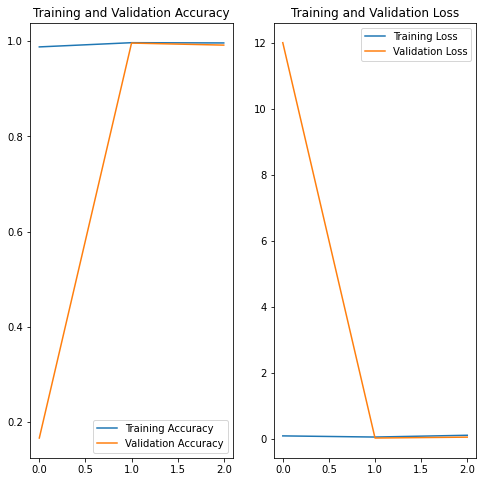

In [123]:

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()